In [2]:
import cv2
import numpy as np

In [3]:
# helper function

def angle_between_3_points(pt1, pt2, pt3):
    """Calculate the angle between three points"""
    
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    pt3 = np.array(pt3)
    
    v1 = pt1 - pt2
    v2 = pt3 - pt2
    
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    
    angle_degrees = np.degrees(angle)
    
    return angle_degrees

def calculate_slope(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return (y2 - y1) / (x2 - x1)

In [6]:
import cv2
import numpy as np

def find_closest_point(p1, p2, contour):
    # convert points to numpy array
    p1 = np.array(p1)
    p2 = np.array(p2)

    # calculate the line parameters
    line_direction = p2 - p1
    line_length = np.linalg.norm(line_direction)
    if line_length == 0:
        return None, None  # points coincide, no line to search
    line_direction = line_direction / line_length
    line_normal = np.array([-line_direction[1], line_direction[0]])

    # initialize minimum distance and closest point
    min_distance = np.inf
    closest_point = None
    closest_point_index = None

    # iterate over all contour points
    for i in range(len(contour)):
        point = contour[i]
        # calculate the distance from the point to the line
        pt_to_p1 = point[0] - p1
        pt_to_p2 = point[0] - p2
        projection = np.dot(pt_to_p1, line_direction) * line_direction
        perpendicular = pt_to_p1 - projection
        distance = np.linalg.norm(perpendicular)
        
        dot_product = np.dot(pt_to_p1, pt_to_p2)
        if dot_product > 0:
            continue

        # if the distance is smaller than the current minimum distance, update the closest point
        if distance < min_distance:
            min_distance = distance
            closest_point = point[0]
            closest_point_index = i
            
    return closest_point, closest_point_index


1. find and draw contours

In [4]:
mask = cv2.imread('created_masks/UCSB-IZC00046621_5x_hef_lg/eyes.png'
                  , cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

### filter the contour points

to do: 
1. how to select the curve based on bounding box and centroid
2. complete and smooth the selected curve

In [7]:
cnt = contours[0]
canvas = np.zeros_like(mask)
canvas.fill(255)
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
cv2.drawContours(canvas, cnt, -1, (0, 255, 0), 5)

# find the bounding box of the contour 
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
left_box_center = ((box[0][0] + box[1][0])//2, (box[0][1] + box[1][1])//2)

cv2.drawContours(canvas,[box],0,(0,255,),5)

M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
centroid_point = (cx,cy)
cv2.circle(canvas, (cx, cy), radius=20, color=(0, 0, 255), thickness=-1)

point1, index1= find_closest_point(centroid_point, tuple(box[2]), cnt)
point2, index2 = find_closest_point(centroid_point, tuple(box[3]), cnt)

direction = "right"
if direction == "right":
    cv2.line(canvas, left_box_center, tuple(box[2]), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.line(canvas, left_box_center, tuple(box[3]), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(canvas, tuple(point1), 20, (255, 0, 0), -1)
    cv2.circle(canvas, tuple(point2), 20, (255, 0, 0), -1)
    print(angle_between_3_points(box[2], centroid_point, box[3]))

line_contour = np.array([left_box_center, tuple(box[2])]).reshape((-1, 1, 2)).astype(np.int32)


## find the intersection between the contour and the line

# for i in range(len(cnt)):
#         pt = tuple(cnt[i][0])
#         dist = cv2.pointPolygonTest(cnt, pt, True)
#         if dist == 0:
#             print("Intersection found at point:", pt)

# intersection between lines and contours(many points)


cv2.namedWindow("binary", cv2.WINDOW_NORMAL)
cv2.imshow('binary', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()



133.44641634986323


In [11]:
## segment the contour 
index = np.sort([index1, index2])
segments = np.split(cnt, index)[1]

In [12]:
canvas = np.zeros_like(mask)
canvas.fill(255)
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
cv2.drawContours(canvas, segments, -1, (0, 255, 0), 5)

cv2.namedWindow("binary", cv2.WINDOW_NORMAL)
cv2.imshow('binary', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()


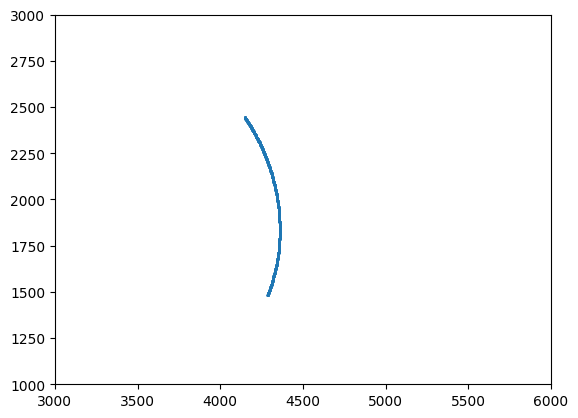

In [16]:
# project contours into R^2 
import matplotlib.pyplot as plt
from scipy.spatial import distance

coords = segments.reshape((len(segments), 2))
x_values = [coord[0] for coord in coords]
y_values = [coord[1] for coord in coords]

plt.xlim(3000, 6000)
plt.ylim(1000, 3000)
plt.scatter(x_values, y_values, s=1)
plt.show()


In [15]:
# distance between adjacent points in the contour
distances = [distance.euclidean(coords[i], coords[i+1]) for i in range(len(coords)-1)]
print(list(set(distances)))
coords.shape

[1.0, 1.4142135623730951]


(1128, 2)

In [324]:
import math

def find_point_on_line(points, total_distance, start_point, start_index):
    accumulated_distance = 0
    current_point = start_point
    
    
    for i in range(start_index+1, len(points)):
        distance = math.sqrt((points[i][0] - current_point[0])**2 + (points[i][1] - current_point[1])**2)
        if accumulated_distance + distance >= total_distance:
            update_index = i
            remaining_distance = total_distance - accumulated_distance
            proportion = remaining_distance / distance
            x = current_point[0] + (points[i][0] - current_point[0]) * proportion
            y = current_point[1] + (points[i][1] - current_point[1]) * proportion
            #print(accumulated_distance)
            return update_index, [x, y]
        else:
            accumulated_distance += distance
            current_point = points[i]
    
    # If we reach the end of the array, return the last point
    return points[-1]


In [388]:
import random

# sample size 
num_omma = 5
omma_diameter_pixel = 15.88732
# make sure no out of range
upper_bound = int(np.ceil(omma_diameter_pixel*num_omma))
new_coords = coords[:-abs(upper_bound)]
start = random.choice(new_coords)

In [389]:
# problem with updating current_index
omma_points = []
current_omma = start
new_coords_omma = coords.copy()
current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

i = 0 
while i < num_omma:
    i += 1
    current_index, next_omma = find_point_on_line(new_coords_omma, omma_diameter_pixel, current_omma, current_index)
    #print(current_index)
    new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
    omma_points.append(next_omma)
    current_omma = next_omma
    


In [390]:
omma_points

[[4353.0, 1954.526893562373],
 [4353.254859978165, 1938.7451400218351],
 [4355.0, 1924.1664671247463],
 [4358.0, 1910.6933606871194],
 [4358.0, 1894.8060406871193]]

In [391]:
[distance.euclidean(omma_points[i], omma_points[i+1]) for i in range(len(omma_points)-1)]

[15.783811276835243,
 14.682752369229803,
 13.803064771260928,
 15.887320000000045]

In [385]:
curve

poly1d([ 2.01392861e-01, -2.63002644e+03,  1.14486542e+07, -1.66121940e+10])

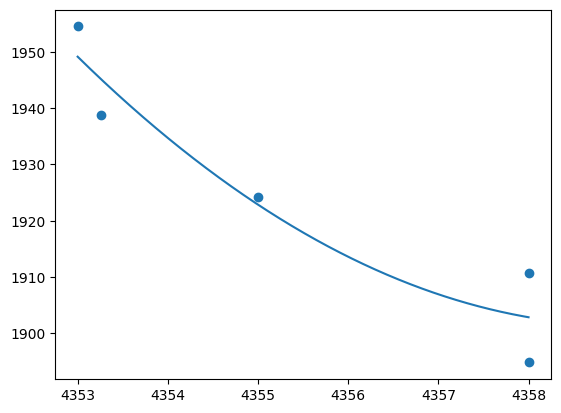

In [392]:
# fit the sampled points to a polynomial regression
from scipy.optimize import curve_fit

# def quadratic(x, a, b, c):
#     return a * x**2 + b * x + c

x = np.array([p[0] for p in omma_points])
y = np.array([p[1] for p in omma_points])

coeffs = np.polyfit(x, y, 2)
curve = np.poly1d(coeffs)
# plot the closed curve 

xp = np.linspace(x[0], x[-1], 1000)
plt.plot(xp, curve(xp))
plt.scatter(x,y)
plt.show()

### Interommatidial Angles

In [375]:
xp[0]
curve(xp[0])

1985.3561894730665

### Radius of Curvature Formula
$$R = \frac{(1+(\frac{dy}{dx})^2)^{3/2}}{\|\frac{d^2 y}{dx}\|}$$

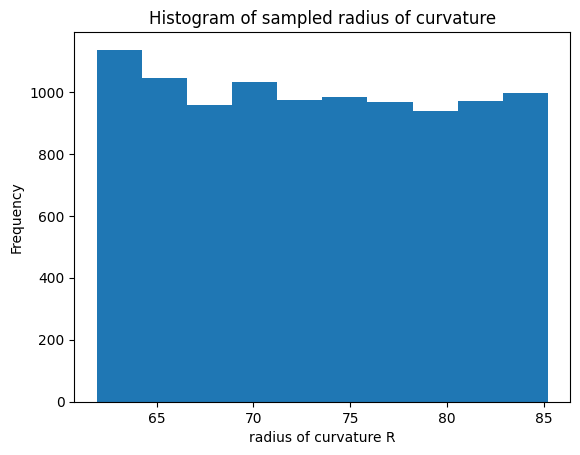

In [374]:
radii_list = []
for i in range(10000):
    x_radius = random.choice(xp) 
    radius = ((1 + deriv1(x_radius)**2)**1.5) / abs(deriv2(x_radius))
    radii_list.append(radius)

plt.hist(radii_list, bins=10)

# Add labels and title
plt.xlabel('radius of curvature R')
plt.ylabel('Frequency')
plt.title('Histogram of sampled radius of curvature')

# Show the plot
plt.show()

### Circle Fitting

In [327]:
def ls_circle(xx,yy):
   asize = np.size(xx)
   #print('Circle input size is ' + str(asize))
   J=np.zeros((asize,3))
   ABC=np.zeros(asize)
   K=np.zeros(asize)

   for ix in range(0,asize):
      x=xx[ix]
      y=yy[ix]

      J[ix,0]=x*x + y*y;
      J[ix,1]=x;
      J[ix,2]=y;
      K[ix]=1.0

   K=K.transpose()
   JT=J.transpose()
   JTJ = np.dot(JT,J)
   InvJTJ=np.linalg.inv(JTJ);

   ABC= np.dot(InvJTJ, np.dot(JT,K))
   #If A is negative, R will be negative
   A=ABC[0]
   B=ABC[1]
   C=ABC[2]

   xofs=-B/(2*A)
   yofs=-C/(2*A)
   R=np.sqrt(4*A + B*B + C*C)/(2*A)
   if R < 0.0: R = -R
   return (xofs,yofs,R)

In [315]:
x = np.array([p[0] for p in omma_points])
y = np.array([p[1] for p in omma_points])

circle_fit = ls_circle(x,y)

Circle input size is 5


In [316]:
print(circle_fit)

(4306.713858316776, 2407.720886947315, 112.08257508611165)


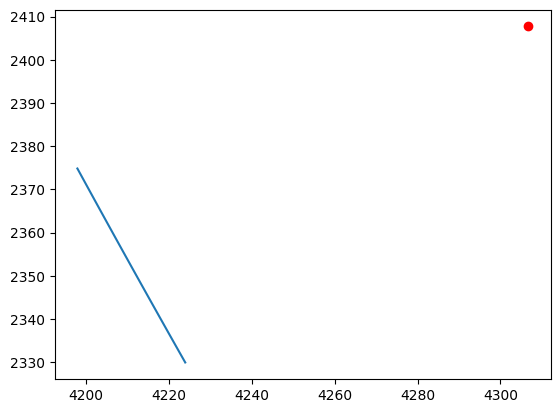

In [317]:
xp = np.linspace(x[0], x[-1], 100)
plt.plot(xp, curve(xp))
plt.scatter(circle_fit[0], circle_fit[1], color = "red")
plt.show()

In [360]:
radius_curvature_list = []
for i in range(10000):
    num_omma = 3
    omma_diameter_pixel = 15.88732
    upper_bound = int(np.ceil(omma_diameter_pixel*num_omma))
    new_coords = coords[:-abs(upper_bound)]
    start = random.choice(new_coords)

    omma_points = []
    current_omma = start
    new_coords_omma = coords.copy()
    current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

    i = 0 
    while i < num_omma:
        i += 1
        current_index, next_omma = find_point_on_line(new_coords_omma, omma_diameter_pixel, current_omma, current_index)
        #print(current_index)
        new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
        omma_points.append(next_omma)
        current_omma = next_omma
    
    x = np.array([p[0] for p in omma_points])
    y = np.array([p[1] for p in omma_points])

    circle_fit = ls_circle(x,y)
    radius_curvature_list.append(circle_fit[2])   

C:\Users\33433\AppData\Local\Temp\ipykernel_37212\1152037251.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  xofs=-B/(2*A)
C:\Users\33433\AppData\Local\Temp\ipykernel_37212\1152037251.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  yofs=-C/(2*A)
C:\Users\33433\AppData\Local\Temp\ipykernel_37212\1152037251.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  R=np.sqrt(4*A + B*B + C*C)/(2*A)
C:\Users\33433\AppData\Local\Temp\ipykernel_37212\1152037251.py:29: RuntimeWarning: invalid value encountered in double_scalars
  yofs=-C/(2*A)


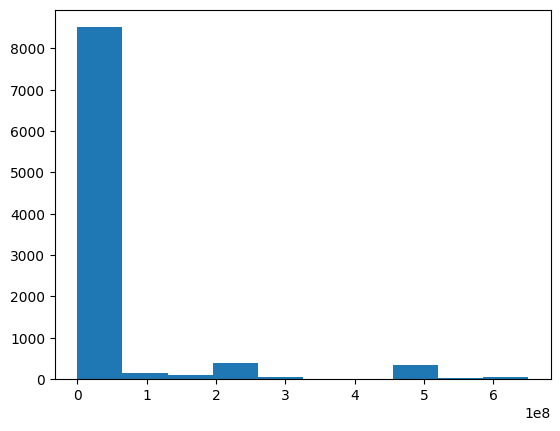

In [361]:
valid_values = [x for x in radius_curvature_list if np.isfinite(x)]

plt.hist(valid_values, range=[min(valid_values), max(valid_values)])
plt.show()

In [345]:
np.max(valid_values)

8069816583.997682

In [320]:
# #from ODA import *
# import cv2
# from funcs import *
# import csv
# from analysis_tools import *


# #  ommatidia N, mean, std, fft 
# img_info = input("Enter the image path: \n")
# img_path = "raw_images/" + img_info


# # Extracting org
# org = img_info.split("-")[0]
# # Extracting bee_id
# bee_id = img_info.split("-")[1].split("_")[0]
# # Extracting zoom_ratio
# zoom_ratio = img_info.split("_")[1]


# pixel_size = get_pixel_size_mm_test(img_path, extension = 300)

In [321]:
#print(pixel_size)